In [1]:
import numpy as np
from scipy import constants as c
from scipy import special as sp
from iminuit import Minuit, cost
from argparse import Namespace
import pandas as pd
import os
import matplotlib.pyplot as plt
import h5py as h5
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from IPython.display import display, Math

C:\Users\ricca\AppData\Local\Temp\ipykernel_4520\2885714771.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
KB = c.Boltzmann
hbar = c.Planck

In [30]:
def resonance_model(x, Q, Qc,phi0):
    return 1-Q/Qc*np.exp(1j*phi0)/(1+1j*((2*x*Q)))

def resonance_model2(x, Q, Qc,phi0):
    return abs(1-Q/Qc*np.exp(1j*phi0)/(1+1j*((2*x*Q))))

def model(x, m, q, Q, Qc,phi0):
    params = np.array([m,q])
    pol = np.polyval(params, x)
    res = resonance_model(x, Q,Qc,phi0)
    return np.abs(res)+pol

def FWHM(x,y):
    x = np.array(x)
    y = np.array(y)
    half = np.max(y) - (np.max(y)-np.abs(y)) / 2.
    minimums = x[np.where(y < half)]
    return (max(minimums) - min(minimums))

def mod(x,y):
    return np.sqrt(x**2 + y**2)
    
def Q_stima(x0,w):
    if (((x0 is None) or (w is None)) or w==0):
        print('Q_stima: None detected!')
        return 0
    else:
        return x0/(2*w)
    
def Sort_Tuple(tup):
 
    # getting length of list of tuples
    lst = len(tup)
    for i in range(0, lst):
        for j in range(0, lst-i-1):
            if (tup[j][1] > tup[j + 1][1]):
                temp = tup[j]
                tup[j] = tup[j + 1]
                tup[j + 1] = temp
    return tup


def plot_res(m2, dfs2, t, func, fill):

    for m in range(len(dfs2)):

        chi2 = m2[m].fval
        ndof = m2[m].ndof
        
        title = [
            f"chi2/ndof = {chi2:.1f}/{ndof}={chi2/ndof:.1f}",
        ]

    for par in m2[m].parameters:
        title.append(
            f"{par} = {m2[m].values[par]:.4f} +/- {m2[m].errors[par]:.4f}"
        )
    
    for n in range(4):
    
        plt.scatter(np.array(dfs2[m][n]['f'])*1e-9, np.array(dfs2[m][n]['S21']), marker='.', s=1, label='Raw Data', color='black')
        plt.plot(np.array(dfs2[m][n]['f'])*1e-9, func(np.array(dfs2[m][n]['f']), *m2[m].values[:]), label='Model', color='red')
        if (fill==True):
            plt.fill_between(np.array(dfs2[m][n]['f'])*1e-9, np.array(dfs2[m][n]['S21'])*(1-(1e-3)), np.array(dfs2[m][n]['S21'])*(1+1e-3), alpha=0.5, color='blue')
        plt.xlabel(r'$\nu$ [GHz]')
        plt.ylabel(r'$|S_{21}|$')
        plt.legend(title="\n".join(title), fontsize='large')
        plt.title('T: '+str(t[m])+' Res: '+str(n))
        plt.grid()
        plt.show()
    return


def plot_res_matrix(m, dfs, t, func, rows, columns, fill):

    fig, ax = plt.subplots(rows, columns, figsize=(60,20))

    for row in range(rows):
        for col in range(columns):
            i = row*columns + col
            chi2 = m[i].fval
            ndof = m[i].ndof

            title = [
                f"chi2/ndof = {chi2:.1f}/{ndof}={chi2/ndof:.1f}",
            ]

            for par in m[i].parameters:
                title.append(
                    f"{par} = {m[i].values[par]:.4f} +/- {m[i].errors[par]:.4f}"
                )
            
            ax[row][col].scatter(np.array(dfs[row][col]['f'])*1e-9, np.array(dfs[row][col]['S21']), marker='.', s=1, label='Raw Data', color='black')
            ax[row][col].plot(np.array(dfs[row][col]['f'])*1e-9, func(np.array(dfs[row][col]['f']), *m[i].values[:]), label='Model', color='red')
            if (fill==True):
                ax[row][col].fill_between(np.array(dfs[row][col]['f'])*1e-9, np.array(dfs[row][col]['S21'])*(1-(1e-3)), np.array(dfs[row][col]['S21'])*(1+1e-3), alpha=0.5, color='blue')
            ax[row][col].set_facecolor('bisque')
            ax[row][col].set_xlabel(r'$\nu$ [GHz]')
            ax[row][col].set_ylabel(r'$|S_{21}|$')
            ax[row][col].legend(title="\n".join(title), fontsize='large')
            ax[row][col].set_title('T: '+str(t[i]))
            ax[row][col].grid()
            fig.tight_layout()

    return fig

def read_files(dir = 'F:\\LabIV\\QTLab2324\\IRdetection\\Instruments\\Test_data\\data_19_02_set2\\'):

    dfs, dictionaries = [], []

    for folder in os.listdir(dir):
        if ('T' in folder):
            parent = dir+folder+'\\'
            dictionaries = []
            for (i,filename) in enumerate(os.listdir(parent)):
                my_dest = filename.replace('.h5','.hdf5')
                my_source = parent + filename
                my_dest = parent + my_dest
                os.rename(my_source, my_dest)
                with h5.File(my_dest, 'r') as r:
                    group = r.require_group(name='raw_data')
                    dic = dict()
                    for c in group.items():
                        dic[c[0]] = c[1][:]
                dictionaries.append(dic)
        dfs.append(dictionaries)
    return dfs

In [19]:
temps = np.arange(60, 320, 20)

In [63]:
dfs = read_files()
for i in range(len(dfs)):
    for j in range(4):
        dfs[i][j]['S21'] = np.sqrt(np.array(dfs[i][j]['i'])**2 + np.array(dfs[i][j]['q'])**2)

In [64]:
min_freq = dfs[0][0]['f'][np.argmin(dfs[0][0]['S21'])]

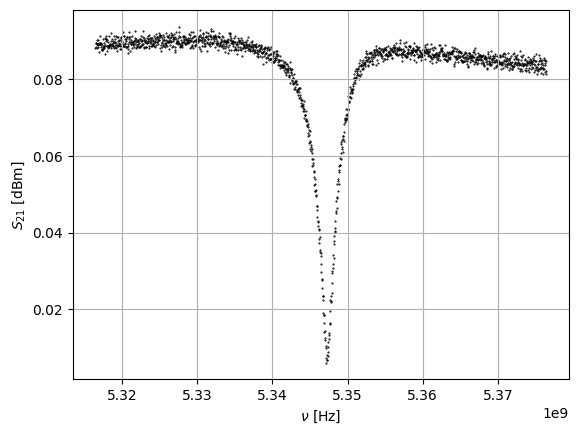

In [65]:
plt.scatter(dfs[0][0]['f'],dfs[0][0]['S21'], marker='.', s=1, color='black')
plt.ylabel(r'$S_{21}$ [dBm]')
plt.xlabel(r'$\nu$ [Hz]')
plt.grid()

We have to estimate $\sigma$\
To do this we will grab the first 100 data points and get the _RMS_

In [66]:
condition = lambda x: (x<5.33*1e9)
fs = [x for x in dfs[0][0]['f'] if condition(x)]
filtered_indices = [i for i, x in enumerate(dfs[0][0]['f']) if condition(x)]
S21s = [dfs[0][0]['S21'][i] for i in filtered_indices]

order = 1 
pol_amp = np.polyfit(fs, S21s, order)
rms = np.sqrt(np.mean((np.polyval(pol_amp, fs)-S21s)**2))
print('RMS: ', rms)

RMS:  0.0011002018335968852


**Let's use data around the resonance minimum**

In [67]:
#condition2 = lambda x: (x>5.335*1e9 and x<5.36*1e9)
#filtered_indices2 = [i for i, x in enumerate(dfs[0][0]['f']) if condition2(x)]
#f = [x for x in dfs[0][0]['f'] if condition2(x)]
#S21 = [dfs[0][0]['S21'][i] for i in filtered_indices2]

In [69]:
f = (dfs[0][0]['f']-min_freq)/min_freq
S21 = dfs[0][0]['S21']/max(dfs[0][0]['S21'])

_Plotting..._

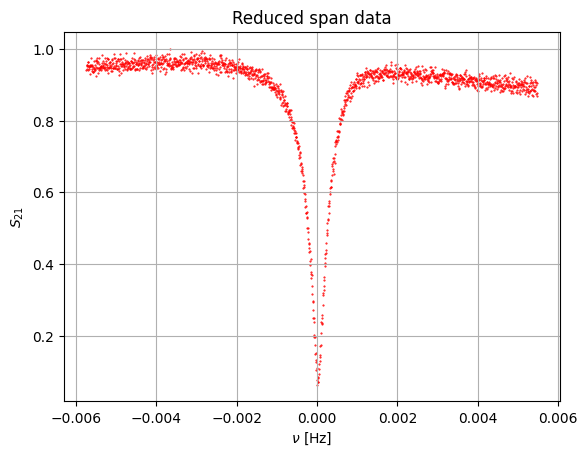

In [70]:
plt.scatter(f,S21,marker='.',s=1, color='red')
plt.xlabel(r'$\nu$ [Hz]')
plt.ylabel('$S_{21}$')
plt.title('Reduced span data')
plt.grid()

Now we have to estimate resonance parameters: $Q$, $Q_{c}$, $\phi_{0}$

In [83]:
f0_init = f[np.argmin(S21)]
m, q = np.polyfit(f, S21,1)
Q_init = Q_stima(f0_init,FWHM(f,S21))
Qc_init = 1.2e3
phi0_init = 0.01
p0_names = ['m','q', '$Q_{i}$', '$Q_{c}$', r'\phi_{0}']
#bounds = [(None, None, None, min_freq*(1-0.1)), (None, None, None,min_freq*(1+0.1))]
p0 = [m, q, 1.3e4, 1e3,-0.077]

In [84]:
lsq = cost.LeastSquares(f, S21, rms, model)

In [85]:
m = Minuit(lsq, *p0)

In [86]:
m.migrad(ncall=10000)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4.508e+05 (χ²/ndof = 282.4)│              Nfcn = 391              │
│ EDM = 1.41e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ m    │  -5.420   │   0.009   │            │            │         │         │       │
│ 1 │ q    │-56.498e-3 │ 0.033e-3  │            │            │         │         │       │
│ 2 │ Q    │ 1.3697e3  │ 0.0004e3  │            │            │         │         │       │
│ 3 │ Qc   │ 1.5925e3  │ 0.0006e3  │            │            │         │         │       │
│ 4 │ phi0 │  0.82e-3  │  0.12e-3  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────┬────────────────────────────────────────────────────────┐
│      │          m          q          Q         Qc       phi0 │
├──────┼────────────────────────────────────────────────────────┤
│    m │   8.25e-05    13.1e-9   -0.02e-3   -0.17e-3   0.384e-6 │
│    q │    13.1e-9   1.08e-09 -6.9241e-6 -8.9872e-6         -0 │
│    Q │   -0.02e-3 -6.9241e-6      0.189       0.14   2.680e-6 │
│   Qc │   -0.17e-3 -8.9872e-6       0.14      0.328  -0.978e-6 │
│ phi0 │   0.384e-6         -0   2.680e-6  -0.978e-6   1.38e-08 │
└──────┴────────────────────────────────────────────────────────┘

<>:14: SyntaxWarning: invalid escape sequence '\c'
<>:14: SyntaxWarning: invalid escape sequence '\c'
C:\Users\ricca\AppData\Local\Temp\ipykernel_4520\613177916.py:14: SyntaxWarning: invalid escape sequence '\c'
  f"$\chi^{2}_{0}$ = {chi2/ndof:.4f}",


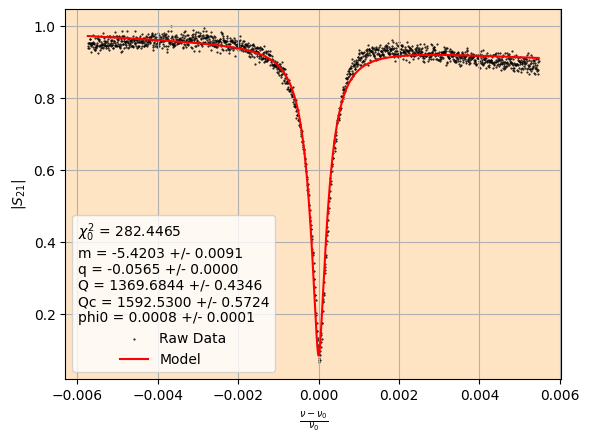

In [88]:
fig, axs = plt.subplots()
axs.scatter(np.array(f), np.array(S21), marker='.', s=1, label='Raw Data', color='black')
axs.plot(np.array(f), model(np.array(f), *m.values[:]), label='Model', color='red')
#plt.fill_between(f, f-rms, f+rms, alpha=0.5, color='blue')
axs.set_xlabel(r'$\frac{\nu- \nu_{0}}{\nu_{0}}$')
axs.set_ylabel(r'$|S_{21}|$')
axs.set_facecolor('bisque')
axs.grid()

chi2 = m.fval
ndof = m.ndof

title = [
    f"$\chi^{2}_{0}$ = {chi2/ndof:.4f}",
]

for par in m.parameters:
    title.append(
        f"{par} = {m.values[par]:.4f} +/- {m.errors[par]:.4f}"
    )
axs.legend(title="\n".join(title))